In [1]:
#  ___________________________________________________________________________
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright (c) 2008-2025
#  National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.
#  ___________________________________________________________________________
"""
Prototype for multi-experiment optimization using the Rooney-Biegler example.
Testing trace (A-optimality) objective.
"""

import pyomo.environ as pyo
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.common.dependencies import pandas as pd, numpy as np


def rooney_biegler_model(data, theta=None):
    model = pyo.ConcreteModel()

    if theta is None:
        theta = {'asymptote': 15, 'rate_constant': 0.5}

    model.asymptote = pyo.Var(initialize=theta['asymptote'])
    model.rate_constant = pyo.Var(initialize=theta['rate_constant'])

    # Fix the unknown parameters
    model.asymptote.fix()
    model.rate_constant.fix()

    # Add the experiment inputs
    model.hour = pyo.Var(initialize=data["hour"].iloc[0], bounds=(0, 10))

    # Fix the experiment inputs
    model.hour.fix()

    # Add the response variable
    model.y = pyo.Var(within=pyo.PositiveReals, initialize=data["y"].iloc[0])

    def response_rule(m):
        return m.y == m.asymptote * (1 - pyo.exp(-m.rate_constant * m.hour))

    model.response_function = pyo.Constraint(rule=response_rule)

    return model


class RooneyBieglerExperiment(Experiment):

    def __init__(self, data, measure_error=None, theta=None):
        self.data = data
        self.model = None
        self.measure_error = measure_error
        self.theta = theta

    def create_model(self):
        # rooney_biegler_model expects a dataframe
        data_df = self.data.to_frame().transpose()
        self.model = rooney_biegler_model(data_df, theta=self.theta)

    def label_model(self):

        m = self.model

        # Add experiment outputs as a suffix
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.y, self.data['y'])])

        # Add unknown parameters as a suffix
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.value(k)) for k in [m.asymptote, m.rate_constant]
        )

        # Add measurement error as a suffix
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update([(m.y, self.measure_error)])

        # Add hour as an experiment input
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update([(m.hour, self.data['hour'])])

        # For multiple experiments, add symmetry breaking constraints
        m.sym_break_cons = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.sym_break_cons[m.hour] = None

    def get_labeled_model(self):
        self.create_model()
        self.label_model()
        return self.model


# Data Setup
data = pd.DataFrame(
    data=[[1, 8.3]],
    # data=[[1, 8.3], [2, 10.3], [3, 19.0], [4, 16.0], [5, 15.6], [7, 19.8]],
    columns=['hour', 'y'],
)
theta = {'asymptote': 15, 'rate_constant': 0.5}
measurement_error = 0.1


print(f"Creating {len(data)} experiments...")
FIM_0 = np.zeros((2, 2))
for i in range(len(data)):
    exp_data = data.loc[i, :]
    exp = RooneyBieglerExperiment(
        data=exp_data, theta=theta, measure_error=measurement_error
    )
    doe_obj = DesignOfExperiments(
        experiment_list=exp,
        objective_option='trace',
        prior_FIM=None,
        tee=False,
        _Cholesky_option=True,
        _only_compute_fim_lower=True,
    )
    FIM_0 += doe_obj.compute_FIM()

FIM_0

Creating 1 experiments...


array([[  15.48181217,  357.97684273],
       [ 357.97684273, 8277.28811613]])

In [2]:
np.linalg.inv(FIM_0)

array([[ 1.08441563e+15, -4.68988970e+13],
       [-4.68988970e+13,  2.02828739e+12]])

In [3]:
np.linalg.det(FIM_0)

np.float64(7.632948009811549e-12)

In [4]:
# Create DoE object with trace (A-optimality) objective
exp.model.hour = 10
doe_obj = DesignOfExperiments(
    experiment_list=exp,
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=True,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [5]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'FIM': [[np.float64(19.67909125534135), np.float64(470.0126444778049)],
  [np.float64(470.0126444778049), np.float64(11267.801882891086)]],
 'Sensitivity Matrix': [[np.float64(0.2048726209312599),
   np.float64(5.468559011989243)]],
 'Experiment Design': [0.4585059038375943],
 'Experiment Design Names': ['hour'],
 'Experiment Outputs': [3.0761624032828294],
 'Experiment Output Names': ['y'],
 'Unknown Parameters': [15.014999999999999, 0.5],
 'Unknown Parameter Names': ['asymptote', 'rate_constant'],
 'Measurement Error': [3.0761624032828294],
 'Measurement Error Names': ['y'],
 'Prior FIM': [[np.float64(15.481812174616982),
   np.float64(357.97684272745516)],
  [np.float64(357.9768427274551), np.float64(8277.28811613021)]],
 'Objective expression': 'determinant',
 'log10 A-opt': np.float64(1.1344536607335713

In [6]:
# Create DoE object with trace (A-optimality) objective
doe_obj = DesignOfExperiments(
    experiment_list=exp,
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=True,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)

# Run optimization
doe_obj.optimize_experiments()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [7]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[114.13876248302037, 458.36548399240223],
    [458.36548399240223, 8379.438844117632]],
   'log10 A-opt': np.float64(-1.9438343410479106),
   'log10 pseudo A-opt': np.float64(3.9290906593290367),
   'log10 D-opt': np.float64(5.872925000376947),
   'log10 E-opt': np.float64(1.9483986224953254),
   'FIM Condition Number': np.float64(94.65155546711813),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [9.999999574520784],
     'Experiment Outputs': [14.913829704285805],
     'Measurement Error': [14.913829704285805],
     'FIM': [[np.float64(98.6569503084034), np.float64(100.38864126494715)],
      [np.float64(100.38864126494715), np.float64(102.1507279874212)]],
     'Sensitivity Matrix': [[np.float64(0.9932620515674774),
       np.float6

In [8]:
import json
designs = np.linspace(0, 10, 100)
designs = np.sort(np.concatenate((designs, [0.4585])))

# Data Setup
data = pd.DataFrame(
    data=[[1, 8.3]],
    # data=[[1, 8.3], [2, 10.3], [3, 19.0], [4, 16.0], [5, 15.6], [7, 19.8]],
    columns=['hour', 'y'],
)
FIM_exp1 = {
    "hour": [],
    "FIM": [],
}
for d in designs:
    data = pd.DataFrame(
        data=[[d, None]],
        columns=['hour', 'y'],
    )    
    exp_data = data.loc[0, :]
    exp = RooneyBieglerExperiment(
        data=exp_data, theta=theta, measure_error=measurement_error
    )
    doe_obj = DesignOfExperiments(
        experiment_list=exp,
        objective_option='trace',
        prior_FIM=None,
        tee=False,
        _Cholesky_option=True,
        _only_compute_fim_lower=True,
    )
    FIM_exp1["hour"].append(float(d))
    FIM_exp1["FIM"].append(doe_obj.compute_FIM().tolist())  # Convert numpy array to list

with open("FIM_exp1.json", "w") as f:
    json.dump(FIM_exp1, f)


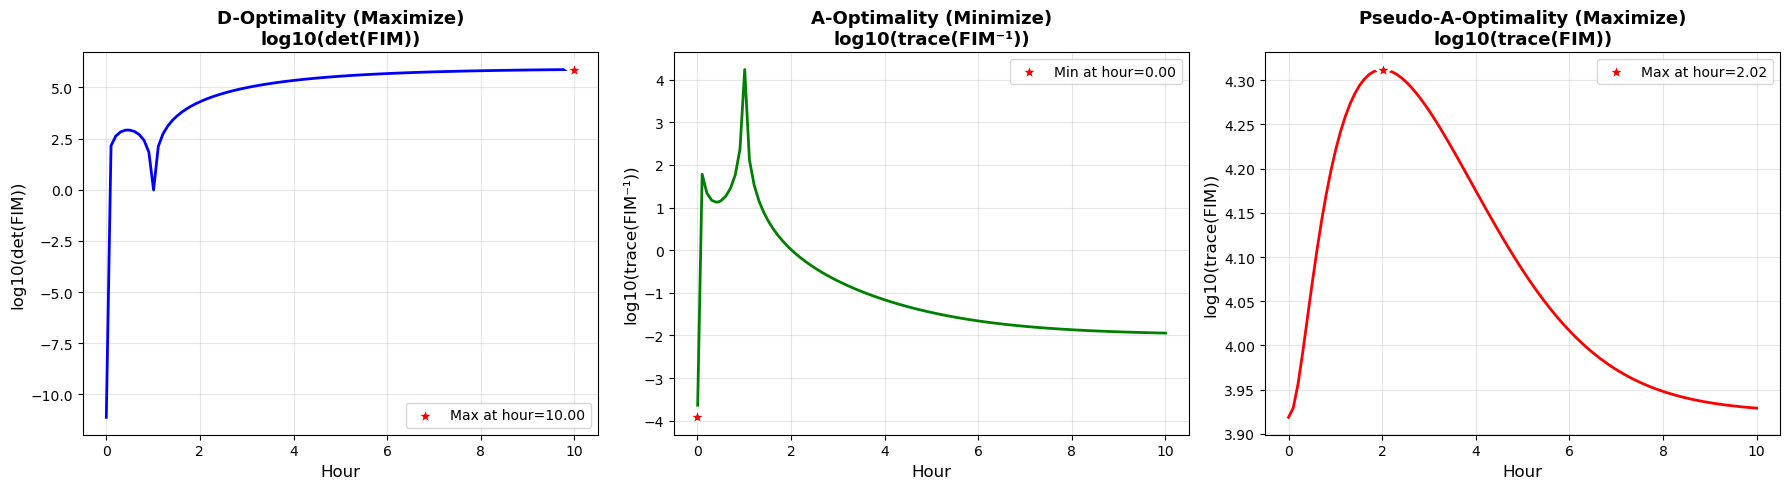


D-Optimality: Max = 5.8729 at hour = 10.00
A-Optimality: Min = -3.9187 at hour = 0.00
Pseudo-A-Optimality: Max = 4.3120 at hour = 2.02


In [9]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
from pyomo.contrib.doe.utils import compute_FIM_metrics

# Load the FIM data
script_dir = Path.cwd()
with open(script_dir / 'FIM_exp1.json', 'r') as f:
    fim_data = json.load(f)

hours = np.array(fim_data['hour'])
fims = [np.array(fim) for fim in fim_data['FIM']]

# Compute metrics for each FIM
d_optimality = []
a_optimality = []
pseudo_a_optimality = []

for fim in fims:
    # Add prior FIM
    fim_with_prior = fim + FIM_0
    try:
        (
            det_FIM,
            trace_cov,
            trace_FIM,
            E_vals,
            E_vecs,
            D_opt,
            A_opt,
            pseudo_A_opt,
            E_opt,
            ME_opt,
        ) = compute_FIM_metrics(fim_with_prior)
        
        d_optimality.append(D_opt)
        a_optimality.append(A_opt)
        pseudo_a_optimality.append(pseudo_A_opt)
    except:
        d_optimality.append(np.nan)
        a_optimality.append(np.nan)
        pseudo_a_optimality.append(np.nan)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# D-optimality plot
ax1 = axes[0]
ax1.plot(hours, d_optimality, 'b-', linewidth=2)
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('log10(det(FIM))', fontsize=12)
ax1.set_title('D-Optimality (Maximize)\nlog10(det(FIM))', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Mark maximum
max_idx = np.nanargmax(d_optimality)
ax1.scatter(hours[max_idx], d_optimality[max_idx], color='red', s=200, marker='*', 
           edgecolors='white', linewidths=2, zorder=5,
           label=f'Max at hour={hours[max_idx]:.2f}')
ax1.legend(loc='best', fontsize=10)

# A-optimality plot
ax2 = axes[1]
ax2.plot(hours, a_optimality, 'g-', linewidth=2)
ax2.set_xlabel('Hour', fontsize=12)
ax2.set_ylabel('log10(trace(FIM⁻¹))', fontsize=12)
ax2.set_title('A-Optimality (Minimize)\nlog10(trace(FIM⁻¹))', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Mark minimum
min_idx = np.nanargmin(a_optimality)
ax2.scatter(hours[min_idx], a_optimality[min_idx], color='red', s=200, marker='*',
           edgecolors='white', linewidths=2, zorder=5,
           label=f'Min at hour={hours[min_idx]:.2f}')
ax2.legend(loc='best', fontsize=10)

# Pseudo-A-optimality plot
ax3 = axes[2]
ax3.plot(hours, pseudo_a_optimality, 'r-', linewidth=2)
ax3.set_xlabel('Hour', fontsize=12)
ax3.set_ylabel('log10(trace(FIM))', fontsize=12)
ax3.set_title('Pseudo-A-Optimality (Maximize)\nlog10(trace(FIM))', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Mark maximum
max_idx = np.nanargmax(pseudo_a_optimality)
ax3.scatter(hours[max_idx], pseudo_a_optimality[max_idx], color='red', s=200, marker='*',
           edgecolors='white', linewidths=2, zorder=5,
           label=f'Max at hour={hours[max_idx]:.2f}')
ax3.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nD-Optimality: Max = {np.nanmax(d_optimality):.4f} at hour = {hours[np.nanargmax(d_optimality)]:.2f}")
print(f"A-Optimality: Min = {np.nanmin(a_optimality):.4f} at hour = {hours[np.nanargmin(a_optimality)]:.2f}")
print(f"Pseudo-A-Optimality: Max = {np.nanmax(pseudo_a_optimality):.4f} at hour = {hours[np.nanargmax(pseudo_a_optimality)]:.2f}")


**Both `run_doe()` and `optimize_experiments()` give the same result when prior using all the data is passed. However, if only data=[[1, 8.3]] is passed then the objective function shows 2 local optima for D- and A-optimality and run_doe() gives one local optima and optimize_experiments() gives the global optima, initialization may change it although did not change the anwer from run_doe().** <br>
See the attached image-
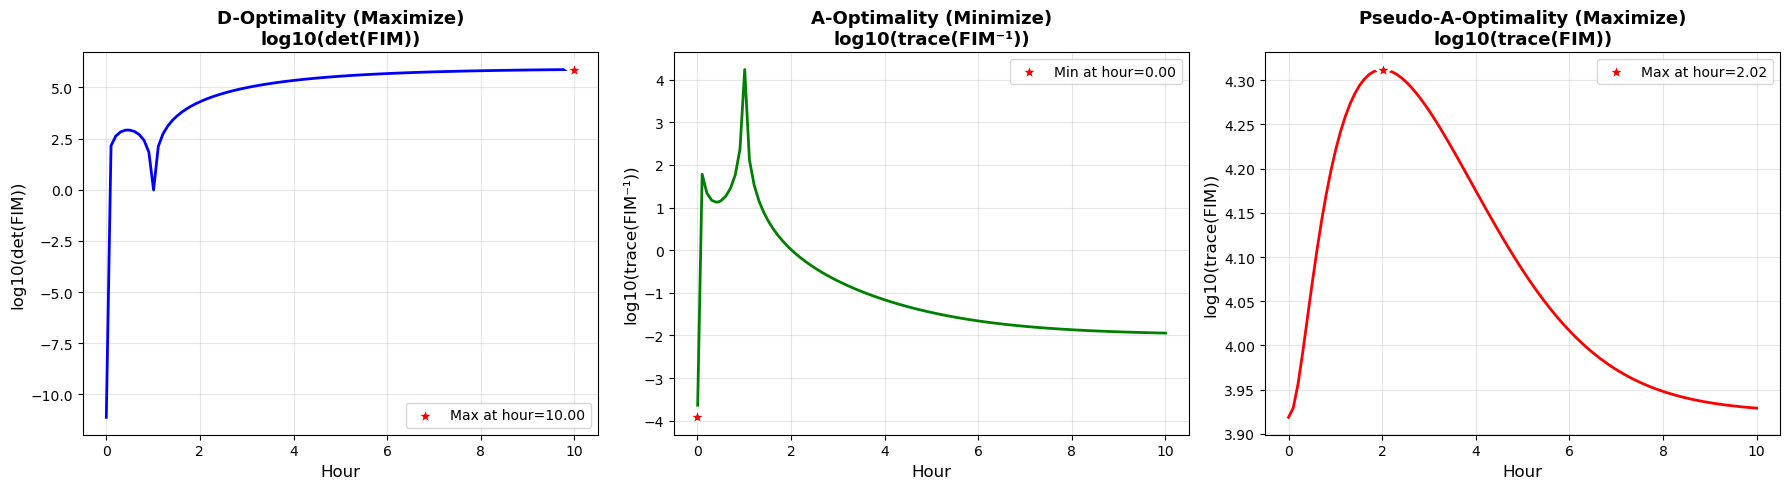
# Multiple experiments
## D-opt

In [10]:
exp1= exp
exp2 = exp
# exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[exp1, exp2],  # We can use it without initialization and still gives same answer
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_dopt.json")

In [11]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[154.52222094797074, 1159.6761391115429],
    [1159.6761391115429, 20558.599770884965]],
   'log10 A-opt': np.float64(-1.9466589849131712),
   'log10 pseudo A-opt': np.float64(4.316245562999631),
   'log10 D-opt': np.float64(6.262904547912803),
   'log10 E-opt': np.float64(1.948525351491906),
   'FIM Condition Number': np.float64(232.19552468356648),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [2.018346655703179],
     'Experiment Outputs': [9.54172929094304],
     'Measurement Error': [9.54172929094304],
     'FIM': [[np.float64(40.383458415989985), np.float64(701.3106580319403)],
      [np.float64(701.3106580319403), np.float64(12179.16093274588)]],
     'Sensitivity Matrix': [[np.float64(0.6354798062565795),
       np.float64(11

# Trace (A-optimality)

In [12]:
exp1 = exp
exp2 = exp
# exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[
        exp1,
        exp2,
    ],  # We can use it without initialization and still gives same answer
    objective_option='trace',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_trace.json")

In [13]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[212.79563066676482, 558.7590109424548],
    [558.7590109424548, 8481.599600157408]],
   'log10 A-opt': np.float64(-2.2347144471687934),
   'log10 pseudo A-opt': np.float64(3.9392393785123514),
   'log10 D-opt': np.float64(6.173953825681145),
   'log10 E-opt': np.float64(2.243555698941072),
   'FIM Condition Number': np.float64(48.62307577864274),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [9.999916529745336],
     'Experiment Outputs': [14.913825503368404],
     'Measurement Error': [14.913825503368404],
     'FIM': [[np.float64(98.65689472916156), np.float64(100.39194773111556)],
      [np.float64(100.39194773111556), np.float64(102.15751465366947)]],
     'Sensitivity Matrix': [[np.float64(0.9932617717860773),
       np.float64

## Pseudo trace

In [14]:
exp1 = exp
exp2 = exp
# exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[
        exp1,
        exp2,
    ],  # We can use it without initialization and still gives same answer
    objective_option='pseudo_trace',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_pseudotrace.json")

In [15]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[95.57484363815165, 1754.7903159616972],
    [1754.7903159616972, 32637.55824110096]],
   'log10 A-opt': np.float64(-0.08751161894972365),
   'log10 pseudo A-opt': np.float64(4.514987576230459),
   'log10 D-opt': np.float64(4.602499195180183),
   'log10 E-opt': np.float64(0.0875278494796498),
   'FIM Condition Number': np.float64(26757.374443735105),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [2.003695763107602],
     'Experiment Outputs': [9.501487927780573],
     'Measurement Error': [9.501487927780573],
     'FIM': [[np.float64(40.0435496731513), np.float64(698.3809577910436)],
      [np.float64(698.3809577910436), np.float64(12180.138028610021)]],
     'Sensitivity Matrix': [[np.float64(0.6327997287898541),
       np.float64(1

# Sensitivity analysis for 2 experiments

In [16]:
#  ___________________________________________________________________________
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright (c) 2008-2025
#  National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.
#  ___________________________________________________________________________
"""
Serial version of FIM computation for all pairwise experiment combinations.
Notebook-compatible version without multiprocessing.
"""

import pyomo.environ as pyo
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.common.dependencies import pandas as pd, numpy as np
import time
import json
from pathlib import Path


def rooney_biegler_model(data, theta=None):
    model = pyo.ConcreteModel()

    if theta is None:
        theta = {'asymptote': 15, 'rate_constant': 0.5}

    model.asymptote = pyo.Var(initialize=theta['asymptote'])
    model.rate_constant = pyo.Var(initialize=theta['rate_constant'])

    # Fix the unknown parameters
    model.asymptote.fix()
    model.rate_constant.fix()

    # Add the experiment inputs
    model.hour = pyo.Var(initialize=data["hour"].iloc[0], bounds=(0, 10))

    # Fix the experiment inputs
    model.hour.fix()

    # Add the response variable
    model.y = pyo.Var(within=pyo.PositiveReals, initialize=data["y"].iloc[0])

    def response_rule(m):
        return m.y == m.asymptote * (1 - pyo.exp(-m.rate_constant * m.hour))

    model.response_function = pyo.Constraint(rule=response_rule)

    return model


class RooneyBieglerExperiment(Experiment):

    def __init__(self, data, measure_error=None, theta=None):
        self.data = data
        self.model = None
        self.measure_error = measure_error
        self.theta = theta

    def create_model(self):
        # rooney_biegler_model expects a dataframe
        data_df = self.data.to_frame().transpose()
        self.model = rooney_biegler_model(data_df, theta=self.theta)

    def label_model(self):

        m = self.model

        # Add experiment outputs as a suffix
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.y, self.data['y'])])

        # Add unknown parameters as a suffix
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.value(k)) for k in [m.asymptote, m.rate_constant]
        )

        # Add measurement error as a suffix
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update([(m.y, self.measure_error)])

        # Add hour as an experiment input
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update([(m.hour, self.data['hour'])])

        # For multiple experiments, we need to add symmetry breaking constraints
        m.sym_break_cons = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.sym_break_cons[m.hour] = None

    def get_labeled_model(self):
        self.create_model()
        self.label_model()
        return self.model


def compute_fim_combination(args):
    """
    Compute FIM for a combination of experiments (without prior).
    Prior FIM will be added later when computing metrics.

    Parameters
    ----------
    args : tuple
        (indices, hours, theta, measurement_error)
        where indices is a tuple of experiment indices,
        and hours is a tuple of corresponding hour values

    Returns
    -------
    dict
        Results dictionary containing hour values, indices, and FIM (without prior)
    """
    indices, hours, theta, measurement_error = args

    # Initialize combined FIM (without prior)
    combined_FIM = np.zeros((2, 2))

    # Compute FIM for each experiment and sum them
    for hour_val in hours:
        # Create data series for this hour value
        data = pd.Series({'hour': hour_val, 'y': 10.0})

        # Create experiment and compute its FIM (without prior)
        exp_obj = RooneyBieglerExperiment(
            data=data, measure_error=measurement_error, theta=theta
        )
        doe_obj = DesignOfExperiments(experiment_list=[exp_obj], prior_FIM=None)
        combined_FIM += doe_obj.compute_FIM()

    # Build result dictionary with dynamic hour fields
    result = {
        'indices': [int(i) for i in indices],
        'FIM': combined_FIM.tolist(),  # FIM without prior
        'log10_det': None,  # Will be computed later with prior
    }

    # Add hour fields dynamically (hour1, hour2, hour3, etc.)
    for idx, hour_val in enumerate(hours, 1):
        result[f'hour{idx}'] = float(hour_val)

    return result


def run_serial(hours, theta, measurement_error, n_experiments=2):
    """Serial computation (notebook-compatible).

    Parameters
    ----------
    hours : array-like
        Array of hour values to use for experiments
    theta : dict
        Parameter values for the model
    measurement_error : float
        Measurement error for experiments
    n_experiments : int, optional
        Number of experiments in each combination (2, 3, or 4), default is 2

    Returns
    -------
    tuple
        (results, elapsed_time)
    """
    from itertools import combinations_with_replacement

    tasks = []
    for indices in combinations_with_replacement(range(len(hours)), n_experiments):
        hour_values = tuple(hours[i] for i in indices)
        tasks.append((indices, hour_values, theta, measurement_error))

    start_time = time.time()
    
    # Compute serially with progress indicator
    results = []
    total = len(tasks)
    print_interval = max(1, total // 20)  # Print progress ~20 times
    
    for i, task in enumerate(tasks):
        if i % print_interval == 0:
            print(f"Progress: {i}/{total} ({100*i/total:.1f}%)")
        results.append(compute_fim_combination(task))
    
    elapsed = time.time() - start_time
    print(f"Progress: {total}/{total} (100.0%)")
    
    return results, elapsed


# Create hour data with dense sampling around optimal region for verification
# Optimal from optimization: hour1≈1.90, hour2≈10.0
hours_p1 = np.linspace(0.1, 1.7, 3)  # Before optimal: coarse
hours_p2 = np.linspace(1.71, 2.1, 5)  # Around optimal hour1: dense
hours_p3 = np.linspace(2.2, 9.4, 3)  # Between: coarse
hours_p4 = np.linspace(9.41, 10, 5)  # Around optimal hour2: dense
hours = np.concatenate((hours_p1, hours_p2, hours_p3, hours_p4))

# Set number of experiments (2, 3, or 4)
n_experiments = 2

# Calculate number of combinations
from math import comb

n_combinations = comb(len(hours) + n_experiments - 1, n_experiments)

print(f"\nVerification Grid Setup:")
print(f"  Total points: {len(hours)}")
print(f"  Range: [{hours[0]:.2f}, {hours[-1]:.2f}]")
print(f"  Dense around hour1≈1.90: [1.71, 2.10] with {len(hours_p2)} points")
print(f"  Dense around hour2≈10.0: [9.41, 10.00] with {len(hours_p4)} points")
print(f"  Number of experiments per combination: {n_experiments}")
print(f"  Total combinations: {n_combinations}")

theta = {'asymptote': 15, 'rate_constant': 0.5}
measurement_error = 0.1

print(f"\nComputing FIM for verification (serial computation)...\n")

# Run serial computation
results_serial, time_serial = run_serial(
    hours, theta, measurement_error, n_experiments
)

print(f"\nComputation completed in {time_serial:.2f} seconds\n")

# Save results to JSON file
file_name = f"rooney_biegler_fim_{n_experiments}exp_verification_w_o_prior.json"
DATA_DIR = Path.cwd()
output_file = DATA_DIR / file_name
print(f"Saving results to {output_file}...")

output_data = {
    'metadata': {
        'n_experiments': n_experiments,
        'n_hours': len(hours),
        'hour_range': [float(hours[0]), float(hours[-1])],
        'total_computations': len(results_serial),
        'theta': theta,
        'measurement_error': measurement_error,
        'computation_method': 'serial',
        'computation_time': time_serial,
        'grid_description': 'Dense sampling around optimal regions (1.71-2.10, 9.41-10), coarse elsewhere',
        'note': 'FIM values stored WITHOUT prior - add FIM_0 when computing metrics',
    },
    'results': results_serial,
}

with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

file_size_mb = len(json.dumps(output_data)) / 1024 / 1024
print(f"Results saved! File size: {file_size_mb:.2f} MB")
print(f"Note: FIM values are stored WITHOUT prior FIM_0")
print(f"      Add FIM_0 when computing metrics in plotting cell")



Verification Grid Setup:
  Total points: 16
  Range: [0.10, 10.00]
  Dense around hour1≈1.90: [1.71, 2.10] with 5 points
  Dense around hour2≈10.0: [9.41, 10.00] with 5 points
  Number of experiments per combination: 2
  Total combinations: 136

Computing FIM for verification (serial computation)...

Progress: 0/136 (0.0%)


Progress: 6/136 (4.4%)
Progress: 12/136 (8.8%)
Progress: 18/136 (13.2%)
Progress: 24/136 (17.6%)
Progress: 30/136 (22.1%)
Progress: 36/136 (26.5%)
Progress: 42/136 (30.9%)
Progress: 48/136 (35.3%)
Progress: 54/136 (39.7%)
Progress: 60/136 (44.1%)
Progress: 66/136 (48.5%)
Progress: 72/136 (52.9%)
Progress: 78/136 (57.4%)
Progress: 84/136 (61.8%)
Progress: 90/136 (66.2%)
Progress: 96/136 (70.6%)
Progress: 102/136 (75.0%)
Progress: 108/136 (79.4%)
Progress: 114/136 (83.8%)
Progress: 120/136 (88.2%)
Progress: 126/136 (92.6%)
Progress: 132/136 (97.1%)
Progress: 136/136 (100.0%)

Computation completed in 20.00 seconds

Saving results to /Users/smondal/Documents/Github/pyomo/pyomo/contrib/doe/examples/multiexperiment-prototype/rooney_biegler_fim_2exp_verification_w_o_prior.json...
Results saved! File size: 0.02 MB
Note: FIM values are stored WITHOUT prior FIM_0
      Add FIM_0 when computing metrics in plotting cell


# Plotting results from the optimization and sensitivity

Optimization result from multiexp_results_dopt.json:
  Hour1: 2.0183, Hour2: 10.0000

Loaded 136 results
Computing FIM metrics for all results...

Valid results: 136

Best D-optimality design:
  Hour1: 2.0025, Hour2: 10.0000
  log10(det): 6.2629

Best A-optimality design (minimize trace of covariance):
  Hour1: 10.0000, Hour2: 10.0000
  log10(trace(cov)): -2.2347

Best Pseudo-A-optimality design (maximize trace of FIM):
  Hour1: 2.0025, Hour2: 2.0025
  log10(trace(FIM)): 4.5150

Grid size: 16 x 16

Plot saved as '/Users/smondal/Documents/Github/pyomo/pyomo/contrib/doe/examples/multiexperiment-prototype/rooney_biegler_fim_metrics_plot.png'


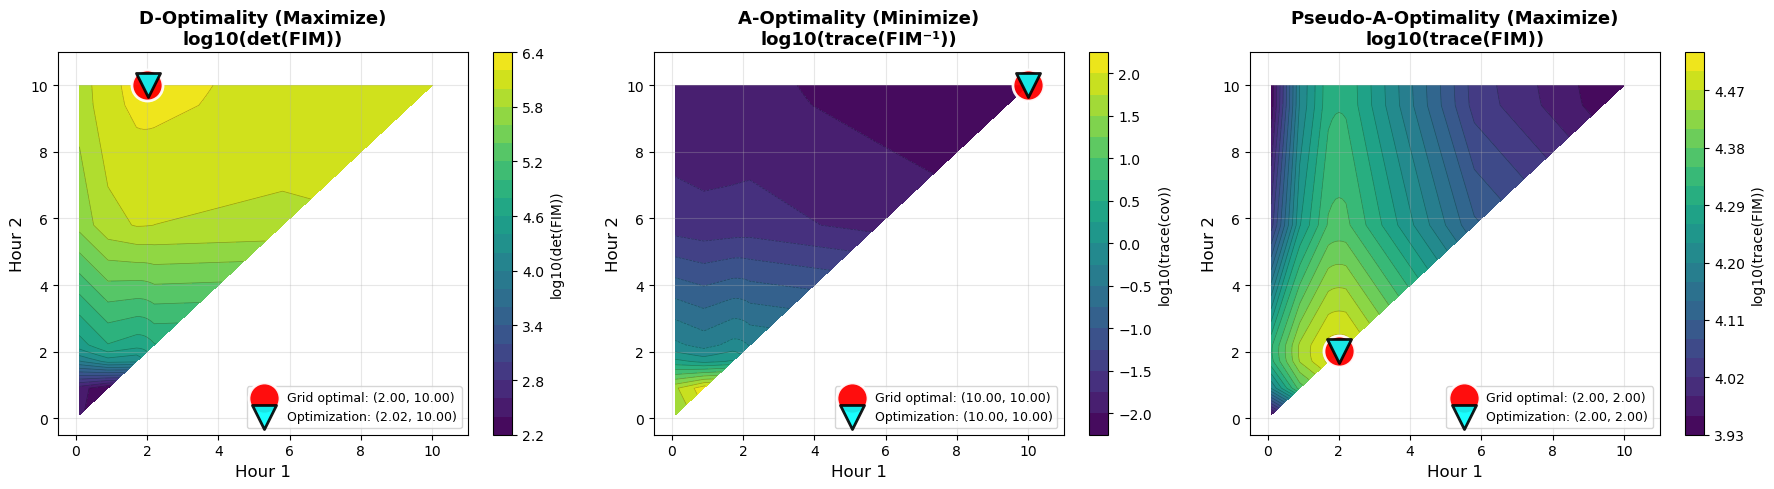

In [17]:
"""
Plot FIM results from rooney_biegler_fim_2exp_verification.json
Creates 2D contour plots for D-optimality, A-optimality, and Pseudo-A-optimality
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys
from pyomo.contrib.parmest.examples.rooney_biegler.rooney_biegler import (
    RooneyBieglerExperiment,
)
from pyomo.contrib.doe import DesignOfExperiments

# Add the parent directory to the path to import from pyomo.contrib.doe
# sys.path.insert(0, str(Path(__file__).parent.parent.parent.parent))
from pyomo.contrib.doe.utils import compute_FIM_metrics

# Get the directory where this script is located
script_dir = Path.cwd()

# Read the results file from the sensitivity analysis
with open(script_dir / 'rooney_biegler_fim_2exp_verification_w_o_prior.json', 'r') as f:
    data = json.load(f)

# Read the optimization results
with open(script_dir / 'multiexp_results_dopt.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_dopt = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_dopt = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]

with open(script_dir / 'multiexp_results_trace.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_trace = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_trace = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]

with open(script_dir / 'multiexp_results_pseudotrace.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_pseudotrace = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_pseudotrace = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]


print(f"Optimization result from multiexp_results_dopt.json:")
print(f"  Hour1: {opt_hour1_dopt:.4f}, Hour2: {opt_hour2_dopt:.4f}\n")
# Convert results to DataFrame
results_df = pd.DataFrame(data['results'])

print(f"Loaded {len(results_df)} results")
print(f"Computing FIM metrics for all results...\n")
# Compute metrics for each result
d_optimality = []
a_optimality = []
pseudo_a_optimality = []

for idx, row in results_df.iterrows():
    # Add prior FIM to the experiment FIM
    FIM = np.array(row['FIM']) + FIM_0
    
    try:
        (
            det_FIM,
            trace_cov,
            trace_FIM,
            E_vals,
            E_vecs,
            D_opt,
            A_opt,
            pseudo_A_opt,
            E_opt,
            ME_opt,
        ) = compute_FIM_metrics(FIM)

        d_optimality.append(D_opt)
        a_optimality.append(A_opt)
        pseudo_a_optimality.append(pseudo_A_opt)
    except:
        d_optimality.append(np.nan)
        a_optimality.append(np.nan)
        pseudo_a_optimality.append(np.nan)

# Add metrics to dataframe
results_df['D_optimality'] = d_optimality
results_df['A_optimality'] = a_optimality
results_df['pseudo_A_optimality'] = pseudo_a_optimality

# Find optimal values for each metric
# D-optimality: maximize
valid_d = results_df[results_df['D_optimality'].notna()].copy()
best_d_idx = valid_d['D_optimality'].idxmax()
best_d = valid_d.loc[best_d_idx]

# A-optimality: minimize (trace of covariance)
valid_a = results_df[results_df['A_optimality'].notna()].copy()
best_a_idx = valid_a['A_optimality'].idxmin()
best_a = valid_a.loc[best_a_idx]

# Pseudo-A-optimality: maximize (trace of FIM)
valid_pa = results_df[results_df['pseudo_A_optimality'].notna()].copy()
best_pa_idx = valid_pa['pseudo_A_optimality'].idxmax()
best_pa = valid_pa.loc[best_pa_idx]

print(f"Valid results: {len(valid_d)}")
print(f"\nBest D-optimality design:")
print(f"  Hour1: {best_d['hour1']:.4f}, Hour2: {best_d['hour2']:.4f}")
print(f"  log10(det): {best_d['D_optimality']:.4f}")

print(f"\nBest A-optimality design (minimize trace of covariance):")
print(f"  Hour1: {best_a['hour1']:.4f}, Hour2: {best_a['hour2']:.4f}")
print(f"  log10(trace(cov)): {best_a['A_optimality']:.4f}")

print(f"\nBest Pseudo-A-optimality design (maximize trace of FIM):")
print(f"  Hour1: {best_pa['hour1']:.4f}, Hour2: {best_pa['hour2']:.4f}")
print(f"  log10(trace(FIM)): {best_pa['pseudo_A_optimality']:.4f}")


# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get unique hour values and create grid
hour1_unique = np.unique(results_df['hour1'])
hour2_unique = np.unique(results_df['hour2'])

print(f"\nGrid size: {len(hour1_unique)} x {len(hour2_unique)}")

# Create meshgrid
H1, H2 = np.meshgrid(hour1_unique, hour2_unique)


# Helper function to create grid for metric
def create_metric_grid(df, metric_name):
    Z = np.full(H1.shape, np.nan)
    for idx, row in df.iterrows():
        i = np.where(hour2_unique == row['hour2'])[0][0]
        j = np.where(hour1_unique == row['hour1'])[0][0]
        Z[i, j] = row[metric_name] if not np.isnan(row[metric_name]) else np.nan
    return Z


# 1. D-optimality plot
ax1 = axes[0]
Z_d = create_metric_grid(results_df, 'D_optimality')
contour1 = ax1.contourf(H1, H2, Z_d, levels=20, cmap='viridis')
ax1.contour(H1, H2, Z_d, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax1.scatter(
    [best_d['hour1']],
    [best_d['hour2']],
    color='red',
    s=500,
    marker='o',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_d["hour1"]:.2f}, {best_d["hour2"]:.2f})',
    zorder=5,
)
# Plot optimal point from optimize_experiments()
ax1.scatter(
    opt_hour1_dopt,
    opt_hour2_dopt,
    color='cyan',
    s=300,
    marker='v',
    edgecolors='black',
    linewidths=2,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_dopt:.2f}, {opt_hour2_dopt:.2f})',
    zorder=5,
)
ax1.set_xlim(-0.5, 11)
ax1.set_ylim(-0.5, 11)
ax1.set_xlabel('Hour 1', fontsize=12)
ax1.set_ylabel('Hour 2', fontsize=12)
ax1.set_title(
    'D-Optimality (Maximize)\nlog10(det(FIM))', fontsize=13, fontweight='bold'
)
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)
fig.colorbar(contour1, ax=ax1, label='log10(det(FIM))')

# 2. A-optimality plot
ax2 = axes[1]
Z_a = create_metric_grid(results_df, 'A_optimality')
contour2 = ax2.contourf(H1, H2, Z_a, levels=20, cmap='viridis')
ax2.contour(H1, H2, Z_a, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax2.scatter(
    [best_a['hour1']],
    [best_a['hour2']],
    color='red',
    s=500,
    marker='o',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_a["hour1"]:.2f}, {best_a["hour2"]:.2f})',
    zorder=5,
)
ax2.scatter(
    opt_hour1_trace,
    opt_hour2_trace,
    color='cyan',
    s=300,
    marker='v',
    edgecolors='black',
    linewidths=2,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_trace:.2f}, {opt_hour2_trace:.2f})',
    zorder=5,
)
ax2.set_xlim(-0.5, 11)
ax2.set_ylim(-0.5, 11)
ax2.set_xlabel('Hour 1', fontsize=12)
ax2.set_ylabel('Hour 2', fontsize=12)
ax2.set_title(
    'A-Optimality (Minimize)\nlog10(trace(FIM⁻¹))', fontsize=13, fontweight='bold'
)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
fig.colorbar(contour2, ax=ax2, label='log10(trace(cov))')

# 3. Pseudo-A-optimality plot
ax3 = axes[2]
Z_pa = create_metric_grid(results_df, 'pseudo_A_optimality')
contour3 = ax3.contourf(H1, H2, Z_pa, levels=20, cmap='viridis')
ax3.contour(H1, H2, Z_pa, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax3.scatter(
    [best_pa['hour1']],
    [best_pa['hour2']],
    color='red',
    s=500,
    marker='o',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_pa["hour1"]:.2f}, {best_pa["hour2"]:.2f})',
    zorder=5,
)
ax3.scatter(
    opt_hour1_pseudotrace,
    opt_hour2_pseudotrace,
    color='cyan',
    s=300,
    marker='v',
    edgecolors='black',
    linewidths=2,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_pseudotrace:.2f}, {opt_hour2_pseudotrace:.2f})',
    zorder=5,
)
ax3.set_xlim(-0.5, 11)
ax3.set_ylim(-0.5, 11)
ax3.set_xlabel('Hour 1', fontsize=12)
ax3.set_ylabel('Hour 2', fontsize=12)
ax3.set_title(
    'Pseudo-A-Optimality (Maximize)\nlog10(trace(FIM))', fontsize=13, fontweight='bold'
)
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(True, alpha=0.3)
fig.colorbar(contour3, ax=ax3, label='log10(trace(FIM))')

plt.tight_layout()
output_path = script_dir / 'rooney_biegler_fim_metrics_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved as '{output_path}'")
plt.show()
